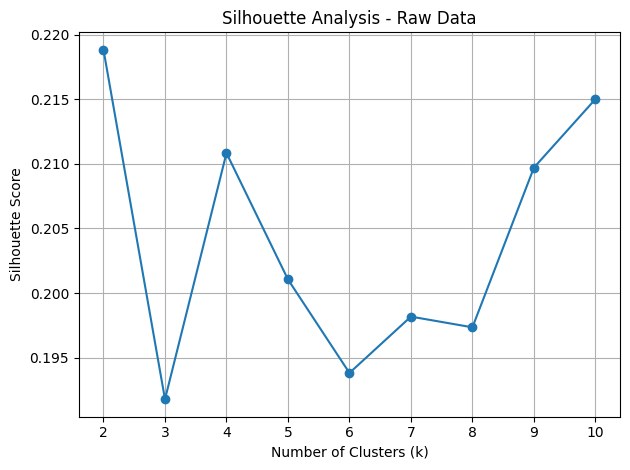

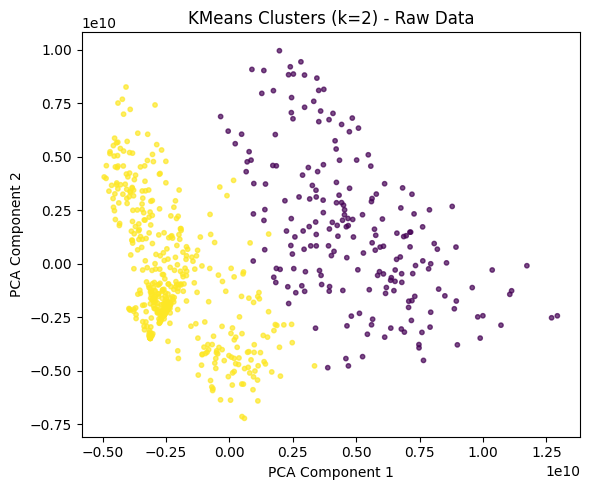

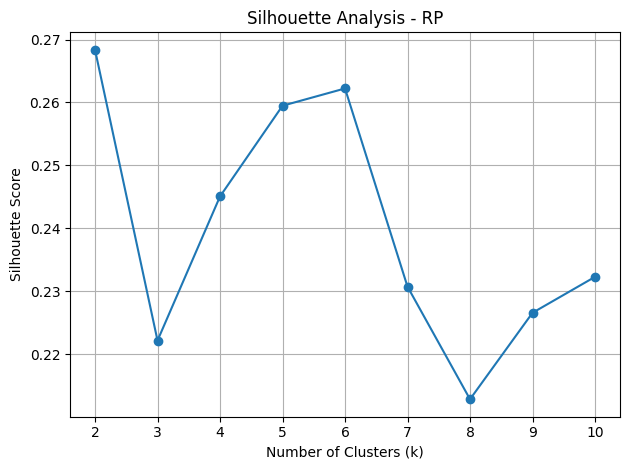

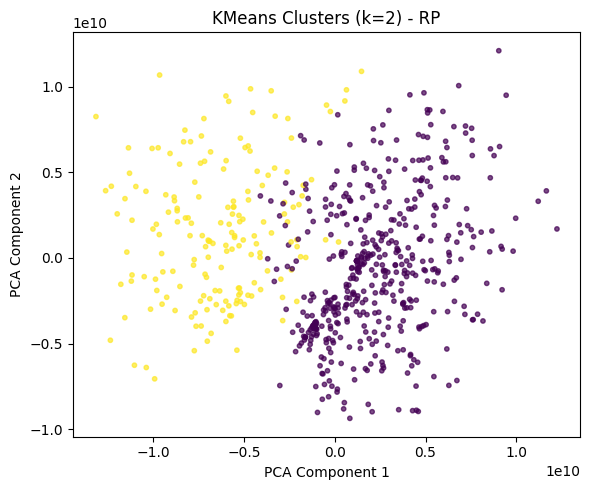

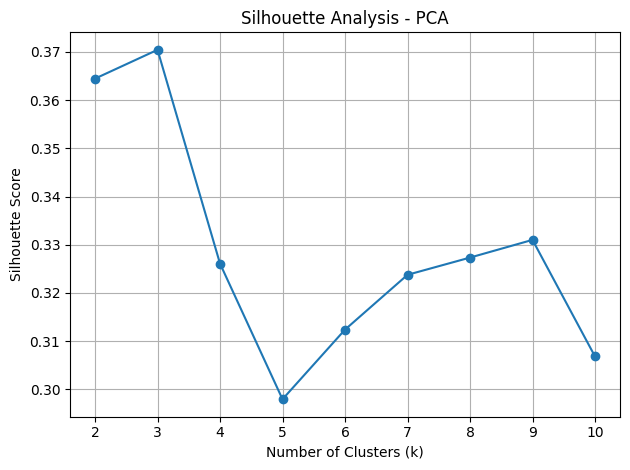

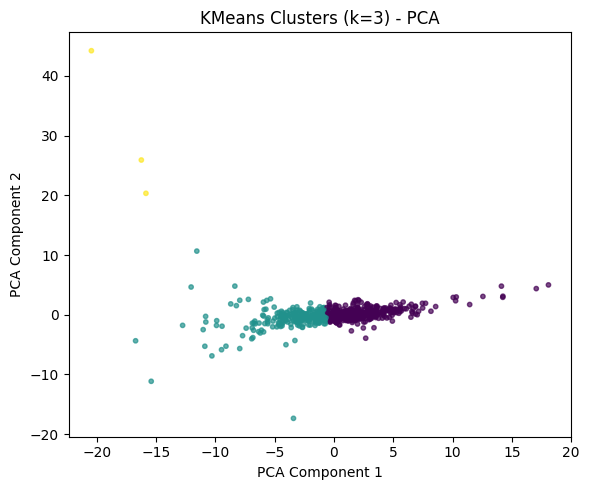

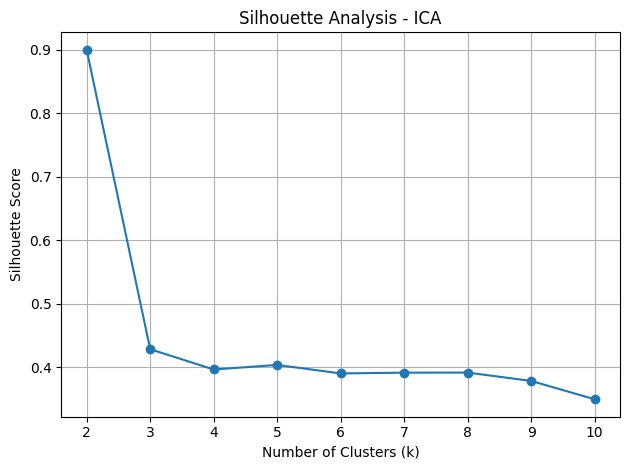

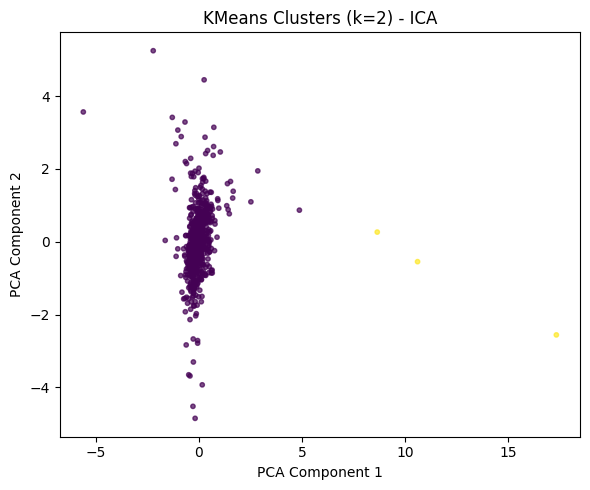

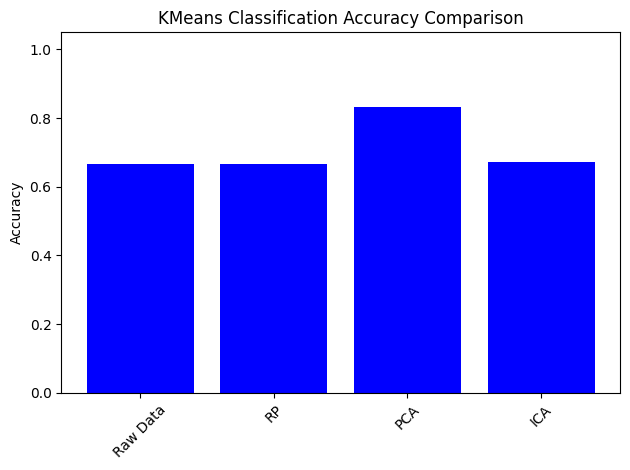

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import mode
import matplotlib.pyplot as plt
import json

# Replace with your file paths
datasets = [
    ("Raw Data", "filtered_bankrupt_data.csv"),
    ("RP", "Bankrupcy_best_random_projection_data.csv"),
    ("PCA", "Bankrupcy_best_pca_data.csv"),
    ("ICA", "Bankrupcy_best_ica_data.csv"),
]

y = pd.read_csv('filtered_bankrupt_outcome.csv').values.ravel()
accuracies = []
optimal_clusters_dict = {}

for name, feature_path in datasets:
    X = pd.read_csv(feature_path).values
    
    silhouette_scores = []
    cluster_range = range(2, 11)

    # Find the optimal number of clusters using silhouette score
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, n_init=5, max_iter=300, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    # Plot silhouette scores
    plt.figure()
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title(f'Silhouette Analysis - {name}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Silhouette_{name.replace(' ', '_')}.png")
    plt.show()

    # Select the best k
    best_k = cluster_range[np.argmax(silhouette_scores)]
    optimal_clusters_dict[name] = best_k

    # Run KMeans with optimal k
    kmeans = KMeans(n_clusters=best_k, n_init=5, max_iter=300, random_state=42)
    clusters = kmeans.fit_predict(X)

    # Map clusters to true labels using majority vote
    labels = np.zeros_like(clusters)
    for i in range(best_k):
        mask = clusters == i
        if np.sum(mask) == 0:
            continue  # avoid empty clusters
        labels[mask] = mode(y[mask], keepdims=True).mode[0]
    
    # Compute accuracy
    acc = accuracy_score(y, labels)
    accuracies.append((name, acc))

    # 2D Cluster plot with PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    plt.figure(figsize=(6, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis', s=10, alpha=0.7)
    plt.title(f'KMeans Clusters (k={best_k}) - {name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()
    plt.savefig(f"KMeans_Clusters_{name.replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()

# Save accuracies to JSON
results_dict = {name: acc for name, acc in accuracies}
with open("bankruptcy_kmeans_accuracies.json", "w") as f:
    json.dump(results_dict, f, indent=4)

# Save optimal clusters to JSON
with open("bankruptcy_kmeans_optimal_clusters.json", "w") as f:
    json.dump(optimal_clusters_dict, f, indent=4)

# Bar chart of accuracy scores
names, scores = zip(*accuracies)
plt.bar(names, scores, color='blue')
plt.ylabel("Accuracy")
plt.title("KMeans Classification Accuracy Comparison")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Bankrupt_KMeans_Acc.png", bbox_inches='tight')
plt.show()


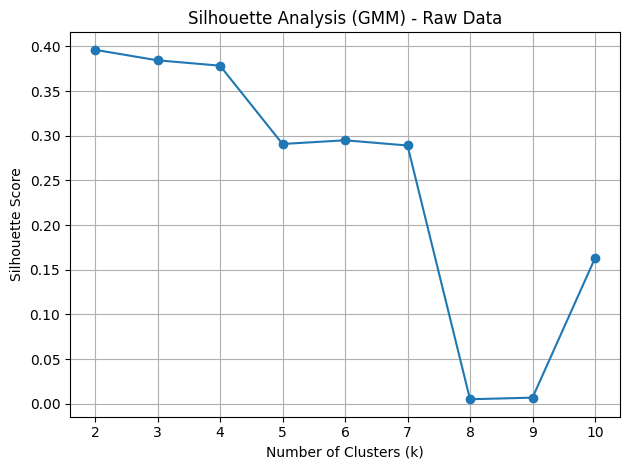

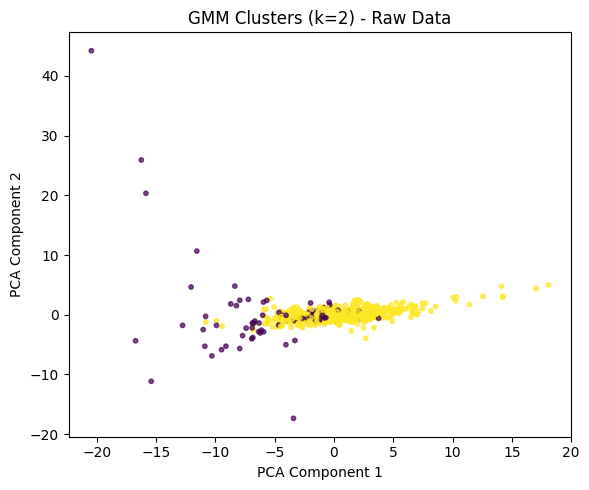

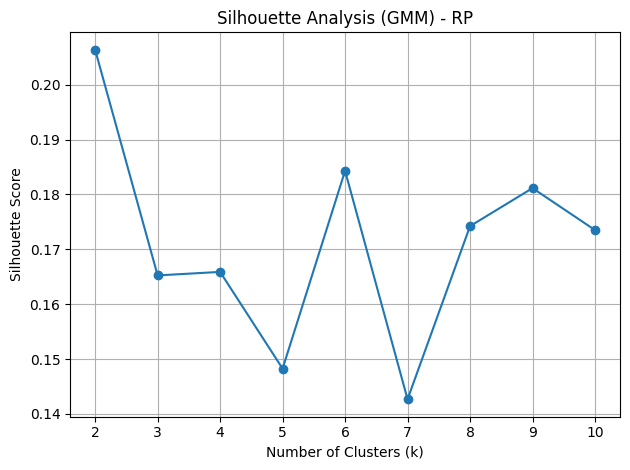

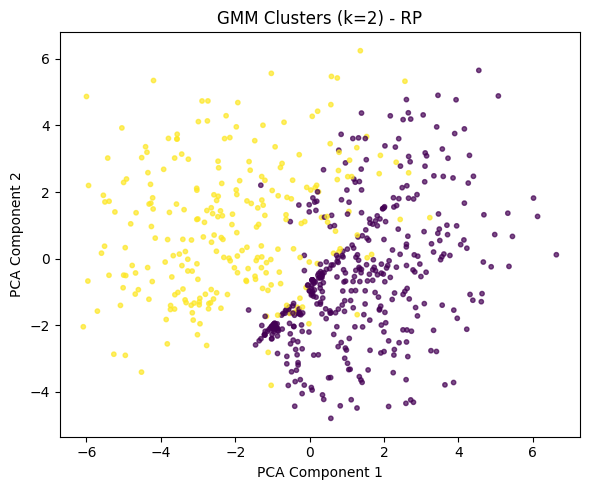

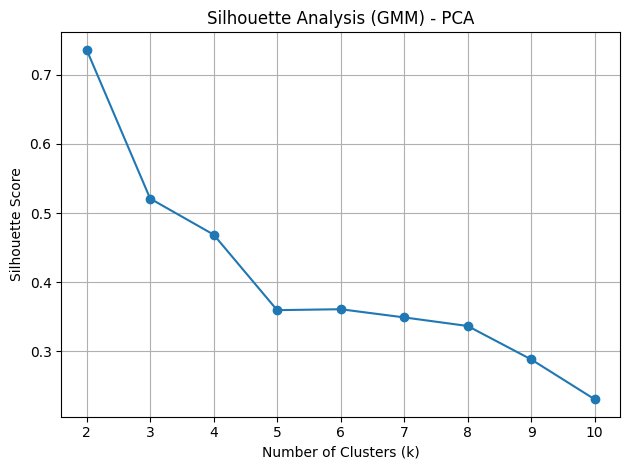

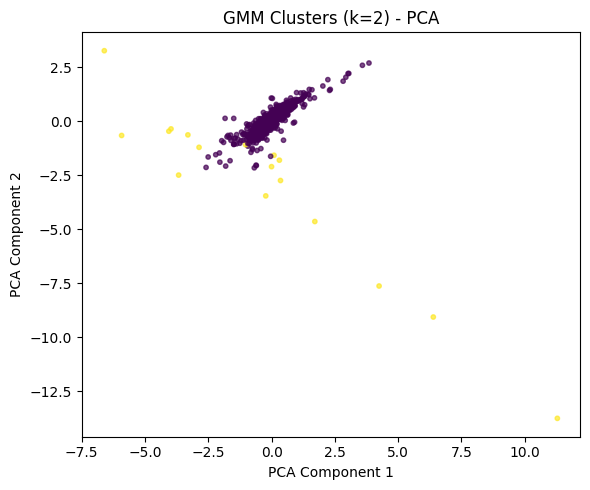

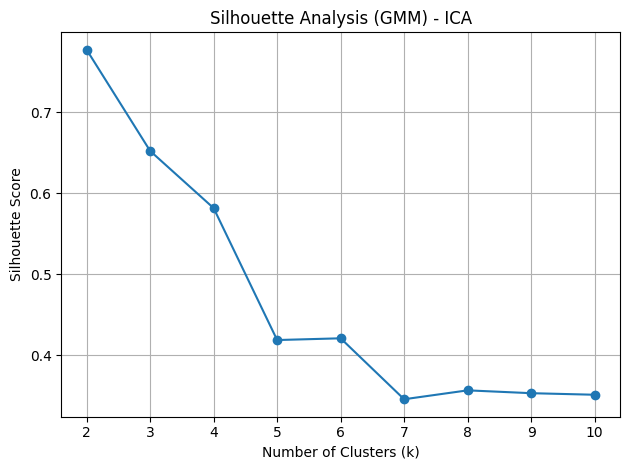

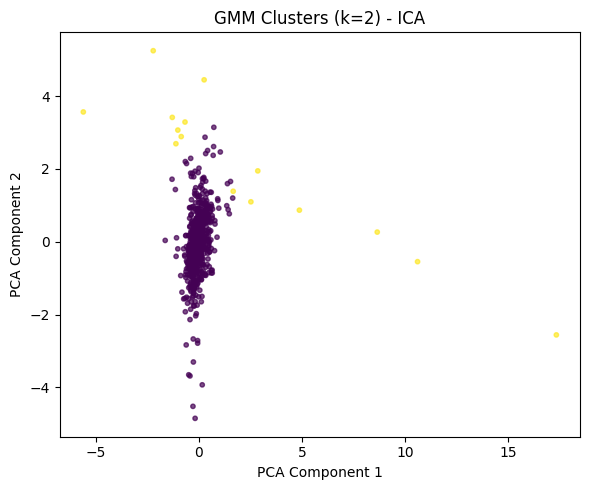

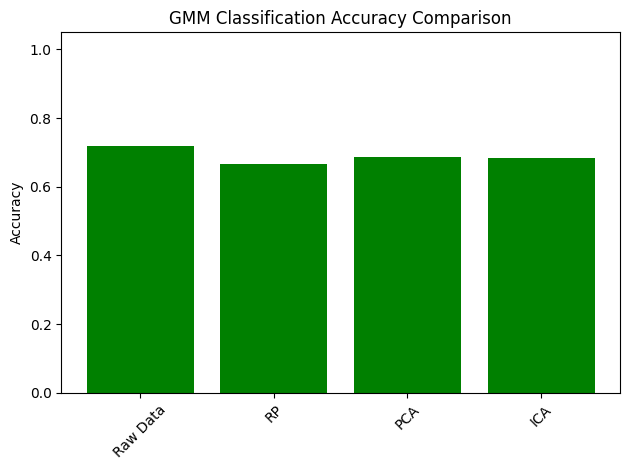

In [16]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from scipy.stats import mode
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import StandardScaler

# File paths
datasets = [
    ("Raw Data", "filtered_bankrupt_data.csv"),
    ("RP", "Bankrupcy_best_random_projection_data.csv"),
    ("PCA", "Bankrupcy_best_pca_data.csv"),
    ("ICA", "Bankrupcy_best_ica_data.csv"),
]

y = pd.read_csv('filtered_bankrupt_outcome.csv').values.ravel()
accuracies = []
optimal_clusters_dict = {}

for name, feature_path in datasets:
    X = pd.read_csv(feature_path).values

    silhouette_scores = []
    cluster_range = range(2,11)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Find best k using silhouette scores
    for k in cluster_range:
        gmm = GaussianMixture(n_components=k, reg_covar=10e-2, random_state=42)
        labels = gmm.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    # Plot silhouette scores
    plt.figure()
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title(f'Silhouette Analysis (GMM) - {name}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Silhouette_GMM_{name.replace(' ', '_')}.png")
    plt.show()

    # Choose best k
    best_k = cluster_range[np.argmax(silhouette_scores)]
    optimal_clusters_dict[name] = best_k

    # Final GMM clustering with best_k
    gmm = GaussianMixture(n_components=best_k, reg_covar=10e-2, random_state=42)
    clusters = gmm.fit_predict(X)

    # Map clusters to labels via majority vote
    labels = np.zeros_like(clusters)
    for i in range(best_k):
        mask = clusters == i
        if np.sum(mask) == 0:
            continue
        labels[mask] = mode(y[mask], keepdims=True).mode[0]

    # Compute accuracy
    acc = accuracy_score(y, labels)
    accuracies.append((name, acc))

    # PCA visualization
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    plt.figure(figsize=(6, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='viridis', s=10, alpha=0.7)
    plt.title(f'GMM Clusters (k={best_k}) - {name}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.tight_layout()
    plt.savefig(f"GMM_Clusters_{name.replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()

# Save results
results_dict = {name: acc for name, acc in accuracies}
with open("bankruptcy_gmm_accuracies.json", "w") as f:
    json.dump(results_dict, f, indent=4)

with open("bankruptcy_gmm_optimal_clusters.json", "w") as f:
    json.dump(optimal_clusters_dict, f, indent=4)

# Accuracy bar plot
names, scores = zip(*accuracies)
plt.bar(names, scores, color='green')
plt.ylabel("Accuracy")
plt.title("GMM Classification Accuracy Comparison")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Bankrupt_GMM_Acc.png", bbox_inches='tight')
plt.show()


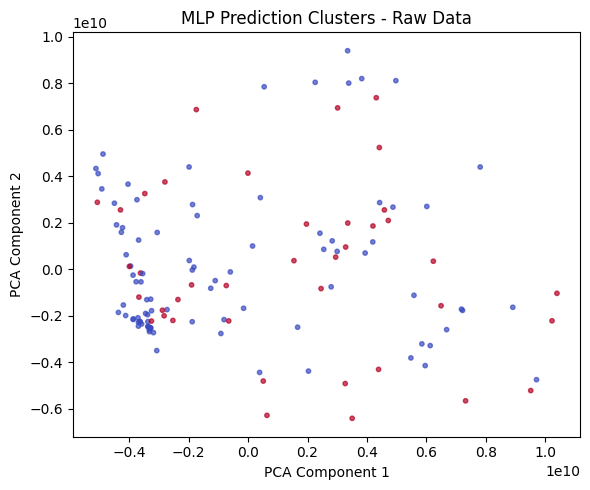

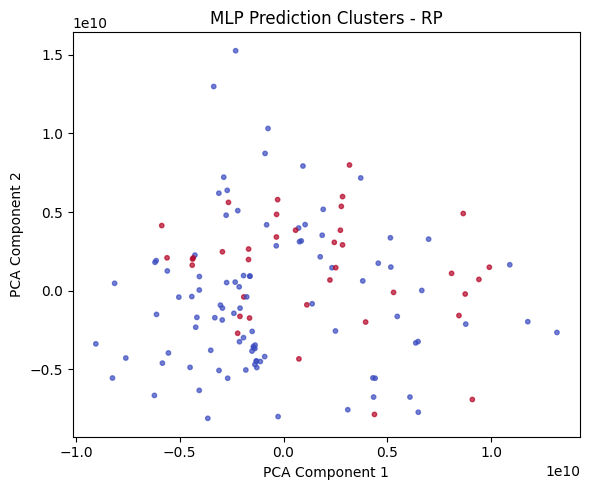

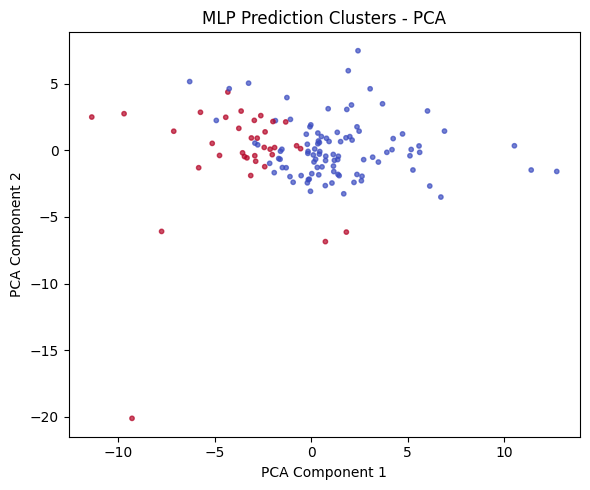

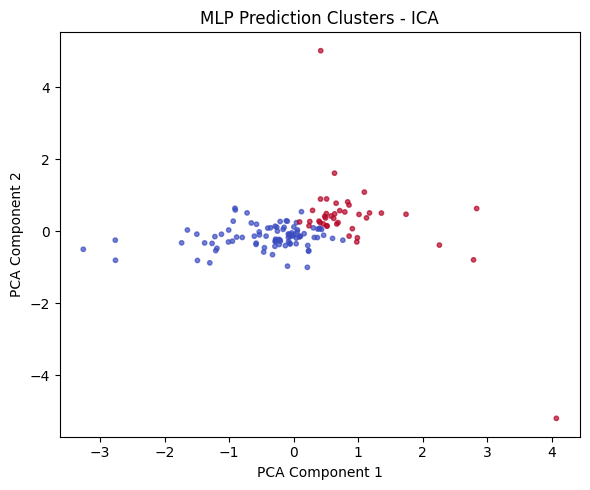

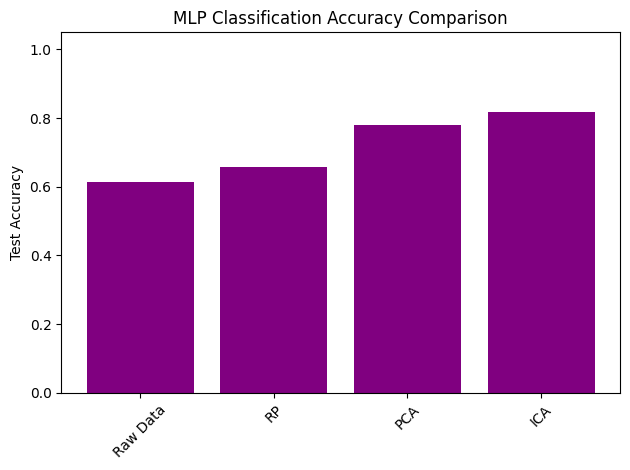

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import json

# Dataset file paths
datasets = [
    ("Raw Data", "filtered_bankrupt_data.csv"),
    ("RP", "Bankrupcy_best_random_projection_data.csv"),
    ("PCA", "Bankrupcy_best_pca_data.csv"),
    ("ICA", "Bankrupcy_best_ica_data.csv"),
]

# Load target labels
y = pd.read_csv('filtered_bankrupt_outcome.csv').values.ravel()

accuracies = {}

for name, feature_path in datasets:
    # Load features
    X = pd.read_csv(feature_path).values
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit MLP neural network
    model = MLPClassifier(hidden_layer_sizes=(128, 128, 64, 64), max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

    # PCA visualization of test predictions
    pca = PCA(n_components=2)
    X_test_2d = pca.fit_transform(X_test)
    
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='coolwarm', s=10, alpha=0.7)
    plt.title(f"MLP Prediction Clusters - {name}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.tight_layout()
    plt.savefig(f"MLP_Clusters_{name.replace(' ', '_')}.png", bbox_inches='tight')
    plt.show()

# Save accuracy results
with open("bankruptcy_mlp_accuracies.json", "w") as f:
    json.dump(accuracies, f, indent=4)

# Plot accuracy comparison
plt.figure()
plt.bar(accuracies.keys(), accuracies.values(), color='purple')
plt.ylabel("Test Accuracy")
plt.title("MLP Classification Accuracy Comparison")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Bankrupt_MLP_Acc.png", bbox_inches='tight')
plt.show()
